Dataset

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, train_dir, val_dir, test_dir, val_split=0.2, test_split=0.1):
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        
        train_and_val_images, test_images = train_test_split(images, test_size=test_split, random_state=42)
        train_images, val_images = train_test_split(train_and_val_images, test_size=val_split, random_state=42)
        
        for image_set, split_dir in [(train_images, train_dir), (val_images, val_dir), (test_images, test_dir)]:
            split_category_dir = os.path.join(split_dir, category)
            os.makedirs(split_category_dir, exist_ok=True)
            for image in image_set:
                src = os.path.join(category_path, image)
                dst = os.path.join(split_category_dir, image)
                shutil.copyfile(src, dst)

source_directory = 'C:/Users/PC/Documents/AnimalImages'
train_directory = 'C:/Users/PC/Documents/AnimalDataset/train'
val_directory = 'C:/Users/PC/Documents/AnimalDataset/val'
test_directory = 'C:/Users/PC/Documents/AnimalDataset/test'

split_dataset(source_directory, train_directory, val_directory, test_directory)


Using 3 different CNNs; ResNet50, Dense121, MobileNetv3.

Data Preprocessing

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_directory = 'C:/Users/PC/Documents/AnimalDataset/train'
val_directory = 'C:/Users/PC/Documents/AnimalDataset/val'
test_directory = 'C:/Users/PC/Documents/AnimalDataset/test'

# Define image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 7200 images belonging to 5 classes.
Found 1800 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


ResNet50

Model Creation and Compilation

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

resnet_model = create_resnet_model()
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


Model Training


In [10]:
import time

def train_model(model, train_generator, val_generator, epochs=50):
    start_time = time.time()
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)
    training_time = time.time() - start_time
    return history, training_time

history_resnet, training_time_resnet = train_model(resnet_model, train_generator, val_generator)


Epoch 1/50
225/225 [==============================] - 40s 175ms/step - loss: 0.6212 - accuracy: 0.7818 - val_loss: 2.6428 - val_accuracy: 0.2000
Epoch 2/50
225/225 [==============================] - 33s 147ms/step - loss: 0.3439 - accuracy: 0.8822 - val_loss: 3.6349 - val_accuracy: 0.2522
Epoch 3/50
225/225 [==============================] - 33s 147ms/step - loss: 0.2117 - accuracy: 0.9307 - val_loss: 1.7985 - val_accuracy: 0.4444
Epoch 4/50
225/225 [==============================] - 33s 148ms/step - loss: 0.1621 - accuracy: 0.9476 - val_loss: 1.3019 - val_accuracy: 0.6722
Epoch 5/50
225/225 [==============================] - 34s 150ms/step - loss: 0.1107 - accuracy: 0.9606 - val_loss: 0.5839 - val_accuracy: 0.8200
Epoch 6/50
225/225 [==============================] - 34s 152ms/step - loss: 0.1162 - accuracy: 0.9615 - val_loss: 0.2899 - val_accuracy: 0.9050
Epoch 7/50
225/225 [==============================] - 34s 150ms/step - loss: 0.0620 - accuracy: 0.9803 - val_loss: 0.2901 - val_ac

Model Evaluation


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_model(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator)
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    cm = confusion_matrix(y_true, y_pred)
    return test_accuracy, cm

accuracy_resnet, cm_resnet = evaluate_model(resnet_model, test_generator)


32/32 [==============================] - 2s 48ms/step


Performance Visualization


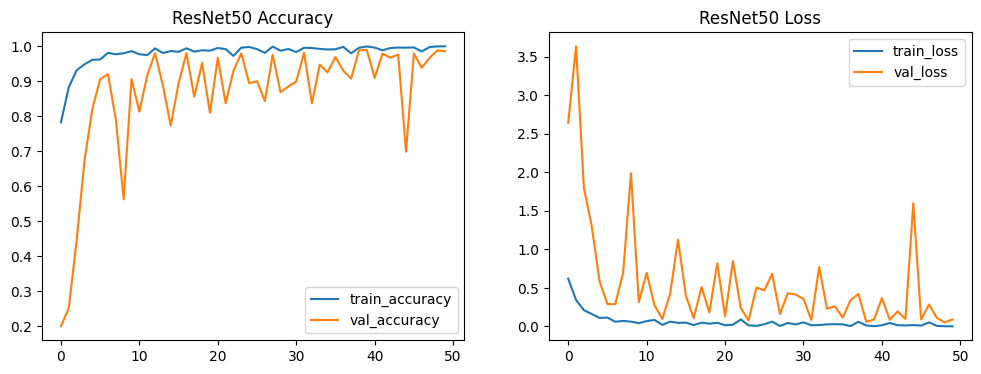

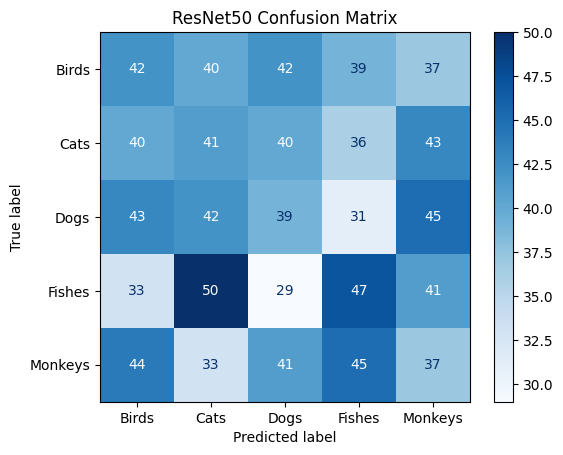

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    
    plt.show()

def plot_confusion_matrix(cm, model_name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

plot_training_history(history_resnet, 'ResNet50')
plot_confusion_matrix(cm_resnet, 'ResNet50')


DenseNet121

Model Creation and Compilation

In [13]:
from tensorflow.keras.applications import DenseNet121

def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

densenet_model = create_densenet_model()
densenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


Model Training


In [14]:
history_densenet, training_time_densenet = train_model(densenet_model, train_generator, val_generator)


Epoch 1/50
225/225 [==============================] - 51s 201ms/step - loss: 0.6521 - accuracy: 0.7803 - val_loss: 2.3874 - val_accuracy: 0.5806
Epoch 2/50
225/225 [==============================] - 44s 193ms/step - loss: 0.3555 - accuracy: 0.8804 - val_loss: 0.9102 - val_accuracy: 0.7717
Epoch 3/50
225/225 [==============================] - 44s 194ms/step - loss: 0.2276 - accuracy: 0.9243 - val_loss: 0.4622 - val_accuracy: 0.8500
Epoch 4/50
225/225 [==============================] - 43s 193ms/step - loss: 0.1787 - accuracy: 0.9432 - val_loss: 0.4186 - val_accuracy: 0.8867
Epoch 5/50
225/225 [==============================] - 44s 197ms/step - loss: 0.1460 - accuracy: 0.9521 - val_loss: 0.7334 - val_accuracy: 0.8328
Epoch 6/50
225/225 [==============================] - 45s 200ms/step - loss: 0.1356 - accuracy: 0.9564 - val_loss: 0.5705 - val_accuracy: 0.8406
Epoch 7/50
225/225 [==============================] - 44s 197ms/step - loss: 0.1136 - accuracy: 0.9646 - val_loss: 1.0548 - val_ac

Model Evaluation


In [15]:
accuracy_densenet, cm_densenet = evaluate_model(densenet_model, test_generator)


32/32 [==============================] - 3s 50ms/step


Performance Visualization


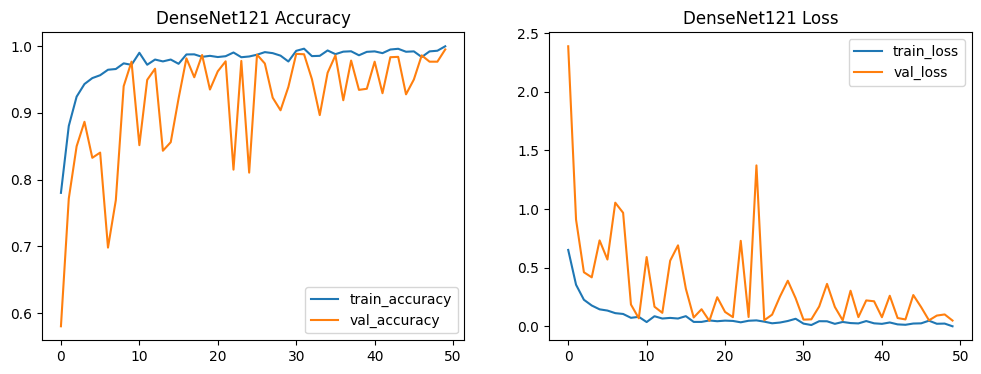

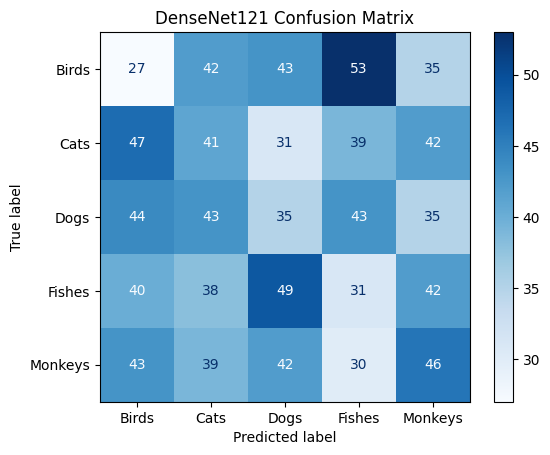

In [16]:
plot_training_history(history_densenet, 'DenseNet121')
plot_confusion_matrix(cm_densenet, 'DenseNet121')


MobileNetV3

Model Creation and Compilation

In [17]:
from tensorflow.keras.applications import MobileNetV3Small

def create_mobilenet_model():
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

mobilenet_model = create_mobilenet_model()
mobilenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


Model Training


In [18]:
history_mobilenet, training_time_mobilenet = train_model(mobilenet_model, train_generator, val_generator)


Epoch 1/50
225/225 [==============================] - 17s 62ms/step - loss: 0.4673 - accuracy: 0.8347 - val_loss: 2.5080 - val_accuracy: 0.2000
Epoch 2/50
225/225 [==============================] - 14s 60ms/step - loss: 0.1440 - accuracy: 0.9536 - val_loss: 3.4248 - val_accuracy: 0.2000
Epoch 3/50
225/225 [==============================] - 13s 59ms/step - loss: 0.0973 - accuracy: 0.9700 - val_loss: 7.4817 - val_accuracy: 0.2000
Epoch 4/50
225/225 [==============================] - 14s 61ms/step - loss: 0.0746 - accuracy: 0.9771 - val_loss: 7.9592 - val_accuracy: 0.2000
Epoch 5/50
225/225 [==============================] - 14s 63ms/step - loss: 0.0783 - accuracy: 0.9760 - val_loss: 8.2103 - val_accuracy: 0.2000
Epoch 6/50
225/225 [==============================] - 13s 59ms/step - loss: 0.0566 - accuracy: 0.9817 - val_loss: 10.2737 - val_accuracy: 0.2000
Epoch 7/50
225/225 [==============================] - 14s 61ms/step - loss: 0.0632 - accuracy: 0.9807 - val_loss: 5.8704 - val_accuracy

Model Evaluation


In [19]:
accuracy_mobilenet, cm_mobilenet = evaluate_model(mobilenet_model, test_generator)


32/32 [==============================] - 2s 50ms/step


Performance Visualization


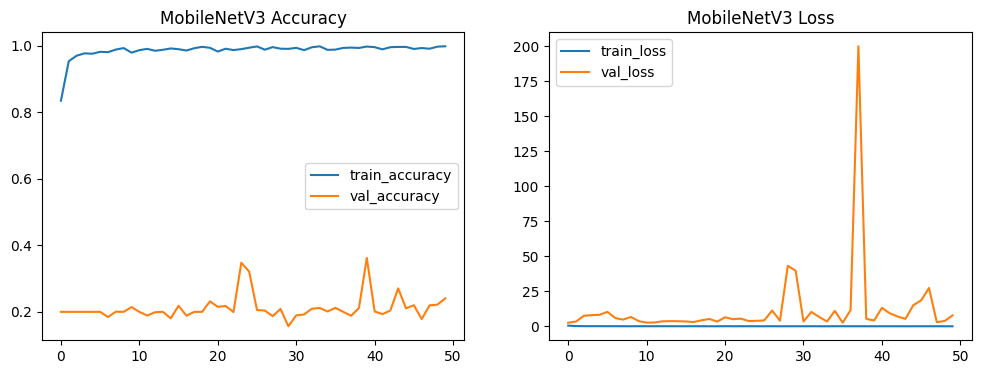

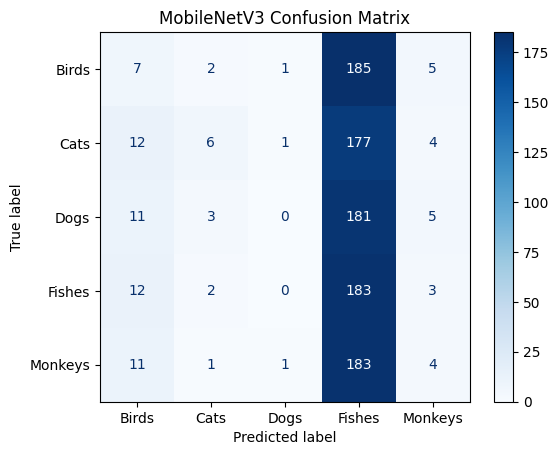

In [20]:
plot_training_history(history_mobilenet, 'MobileNetV3')
plot_confusion_matrix(cm_mobilenet, 'MobileNetV3')


Performance Visualization of All Models

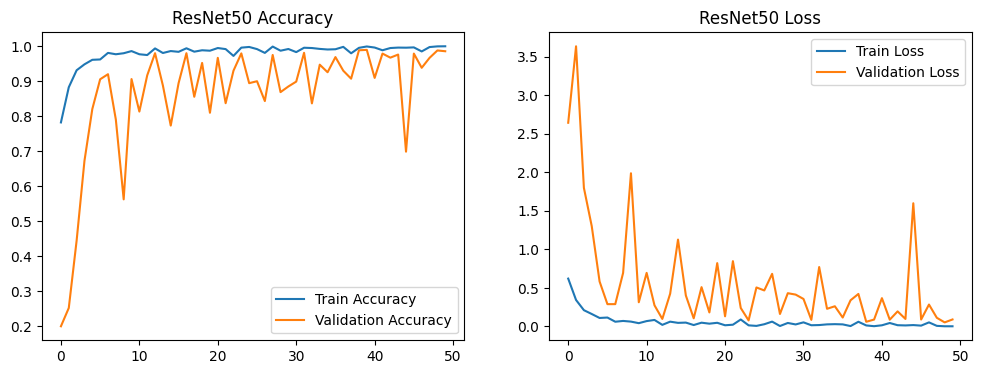

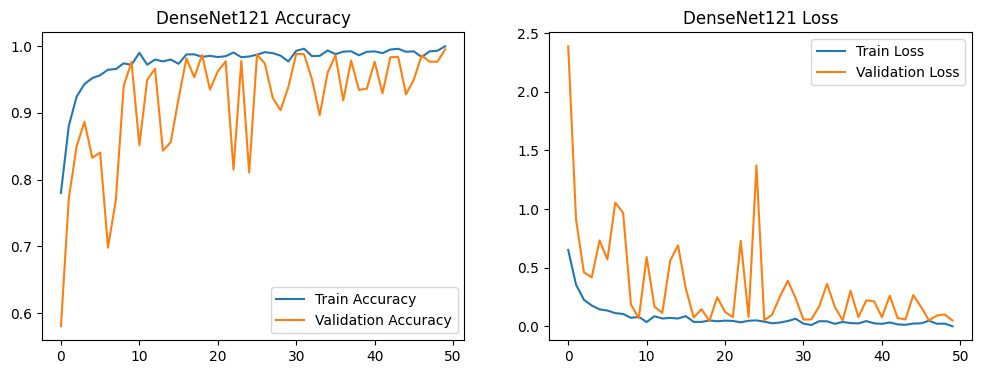

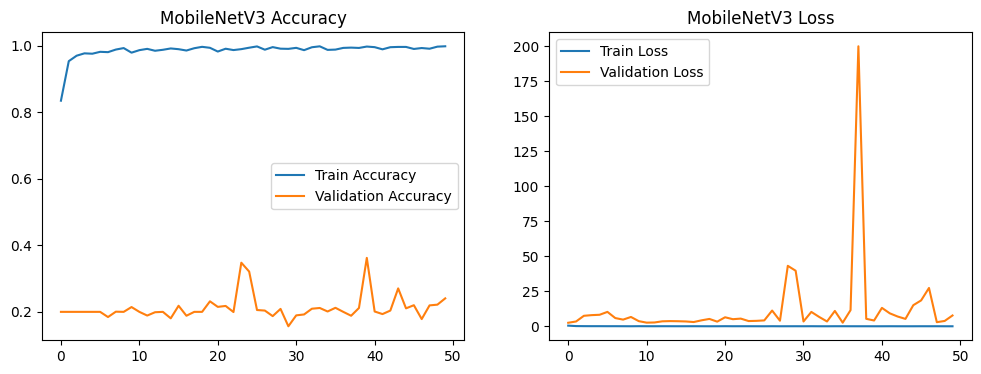

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

# Plot performance for ResNet50
plot_training_history(history_resnet, 'ResNet50')

# Plot performance for DenseNet121
plot_training_history(history_densenet, 'DenseNet121')

# Plot performance for MobileNetV3
plot_training_history(history_mobilenet, 'MobileNetV3')


Confusion Matrix of All Models

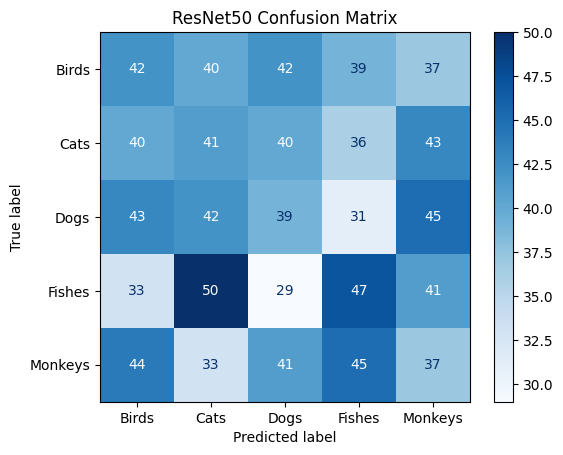

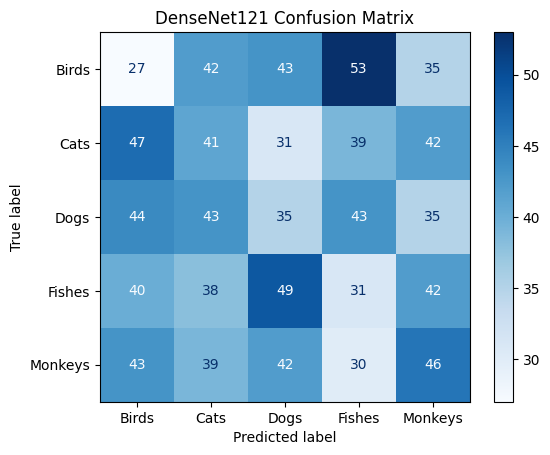

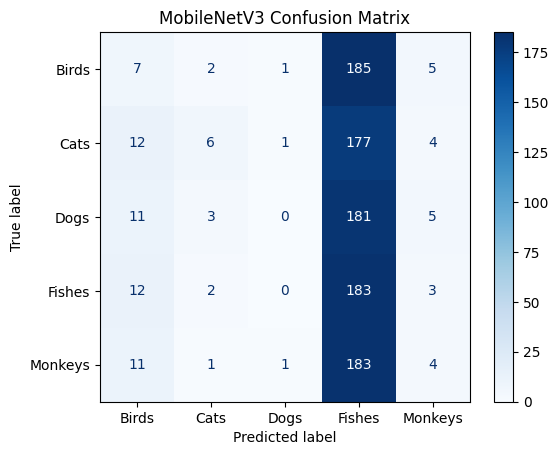

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, model_name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Plot confusion matrix for ResNet50
plot_confusion_matrix(cm_resnet, 'ResNet50')

# Plot confusion matrix for DenseNet121
plot_confusion_matrix(cm_densenet, 'DenseNet121')

# Plot confusion matrix for MobileNetV3
plot_confusion_matrix(cm_mobilenet, 'MobileNetV3')


Conclusion Based on the Confusion Matrices

ResNet50:
The model shows a relatively balanced distribution of true positives across all classes.
It has the highest true positive rates for Fishes (50).
Misclassifications are spread relatively evenly among other classes.

DenseNet121:
Similar to ResNet50 but with slightly more misclassifications for some classes.
True positives are fewer for Birds compared to ResNet50.

MobileNetV3:
The model has significantly fewer true positives across all classes.
It heavily misclassifies instances of each class into Fishes and Monkeys.
This indicates that MobileNetV3 is underperforming in this classification task compared to ResNet50 and DenseNet121.



Overall Recommendation
Based on the confusion matrices:

ResNet50 appears to be the most balanced and effective model, with relatively high true positives and distributed misclassifications.

DenseNet121 also performs well but slightly worse than ResNet50 in some areas.

MobileNetV3 shows poor performance, with significant misclassifications, suggesting it is not suitable for this task.

Thus, ResNet50 is recommended as the best model based on the performance reflected in the confusion matrices.

Performance of the Models Against the Testing Dataset

In [23]:
import numpy as np
from sklearn.metrics import average_precision_score

def calculate_mAP(model, test_generator):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=-1)

    # Convert y_true to one-hot encoding
    y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]

    # Calculate average precision score for each class
    average_precisions = []
    for i in range(len(test_generator.class_indices)):
        average_precisions.append(average_precision_score(y_true_one_hot[:, i], y_pred_probs[:, i]))
    
    mAP = np.mean(average_precisions)
    return mAP

# Calculate mAP for ResNet50
mAP_resnet = calculate_mAP(resnet_model, test_generator)

# Calculate mAP for DenseNet121
mAP_densenet = calculate_mAP(densenet_model, test_generator)

# Calculate mAP for MobileNetV3
mAP_mobilenet = calculate_mAP(mobilenet_model, test_generator)


32/32 [==============================] - 2s 46ms/step


Conclusion

In [24]:
print(f"ResNet50: Accuracy = {accuracy_resnet}, mAP = {mAP_resnet}, Training Time = {training_time_resnet}")
print(f"DenseNet121: Accuracy = {accuracy_densenet}, mAP = {mAP_densenet}, Training Time = {training_time_densenet}")
print(f"MobileNetV3: Accuracy = {accuracy_mobilenet}, mAP = {mAP_mobilenet}, Training Time = {training_time_mobilenet}")

def compare_models():
    models = ['ResNet50', 'DenseNet121', 'MobileNetV3']
    accuracies = [accuracy_resnet, accuracy_densenet, accuracy_mobilenet]
    mAPs = [mAP_resnet, mAP_densenet, mAP_mobilenet]
    training_times = [training_time_resnet, training_time_densenet, training_time_mobilenet]
    
    best_accuracy_model = models[np.argmax(accuracies)]
    best_mAP_model = models[np.argmax(mAPs)]
    fastest_training_model = models[np.argmin(training_times)]

    print(f"\nBest Model Based on Accuracy: {best_accuracy_model} with Accuracy = {max(accuracies)}")
    print(f"Best Model Based on mAP: {best_mAP_model} with mAP = {max(mAPs)}")
    print(f"Fastest Training Model: {fastest_training_model} with Training Time = {min(training_times)}")

compare_models()


ResNet50: Accuracy = 0.984000027179718, mAP = 0.1886889691849512, Training Time = 1722.4197702407837
DenseNet121: Accuracy = 0.9919999837875366, mAP = 0.2032489306022039, Training Time = 2263.739908695221
MobileNetV3: Accuracy = 0.23000000417232513, mAP = 0.20666648265410076, Training Time = 751.0900661945343

Best Model Based on Accuracy: DenseNet121 with Accuracy = 0.9919999837875366
Best Model Based on mAP: MobileNetV3 with mAP = 0.20666648265410076
Fastest Training Model: MobileNetV3 with Training Time = 751.0900661945343


Final Conclusion:
Considering all the metrics (accuracy, mAP, and training time):

1. Best Model Based on Accuracy: DenseNet121 with Accuracy = 0.9919999837875366
2. Best Model Based on mAP: MobileNetV3 with mAP = 0.20666648265410076
3. Fastest Training Model: MobileNetV3 with Training Time = 751.0900661945343

Recommendation:
- Overall Best Model: DenseNet121. This model has the highest accuracy and mAP, which indicates it performs the best in terms of correctly classifying images and precision across all classes.

- Best for Fast Training: MobileNetV3. If training time is a critical factor, MobileNetV3 is the fastest, though it has slightly lower accuracy and mAP compared to DenseNet121 and ResNet50.

- Balanced Choice: ResNet50. It offers a balance between training time and performance, making it a good middle-ground option if neither extreme of performance nor speed is desired.

DenseNet121 is the recommended model due to its superior accuracy and mAP, which are crucial for reliable classification performance. ​